<a href="https://colab.research.google.com/github/gheorghebg11/Shell/blob/master/Shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the files into Colab

The first cells are for loading the big data files from google drive (as colab only keeps the files for 12 hours), and the .csv from my local drive or dropbox. We first authenticate.

In [231]:
!pip install PyDrive
import os, zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now download the files and un unzip the archives. Right now there are 4 folders for 4 different gas station brands.

In [3]:
!rm -r /content/data
!mkdir /content/data
print('\nDownloading the data')
download = drive.CreateFile({'id': '1e5u2uDQ5mupV64KJbmWVG-JhlGKz9uUD'})
download.GetContentFile('/content/data_shell.tar.gz')
!tar -xzf /content/data_shell.tar.gz -C /content/data
print('\nData successfully downloaded in /content/data')
!rm /content/data_shell.tar.gz
!rm -r /content/sample_data



Data successfully downloaded in /content/data


# Data Visualization and Basic Cleaning (can be skipped)

First load some packages for Data Visualization.

In [0]:
import numpy as np
np.random.seed(1989)

import os
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns = 20

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

Explore the data a little bit. We look at the available categories (each in one separate folder) and create a dictionary for one-hot encoding.

In [0]:
dir_data = '/content/data/'
labels = list(os.listdir(dir_data))

We will now loop through all files and do a few tasks:
- check for corrupted files (ending in .part)
- check for all available extensions, in order to exlcude non-images
- rename each file in the formal 'label_oldfilename' and move them all in one single folder.

In [146]:
extensions = set()

for label in labels:
    dir_label = os.path.join(dir_data, label)
    filenames = [name for name in os.listdir(dir_label) if os.path.isfile(os.path.join(dir_label, name))]
    
    for filename in filenames:
        new_filename = label + '_' + filename
        os.rename(os.path.join(dir_label, filename), os.path.join(dir_data,new_filename))
        
        # check for the extension
        extension = filename.split('.')[-1]
        if extension not in extensions:
            extensions.add(extension)
    
    # erase the empty folder
    os.rmdir(os.path.join(dir_data, label))
    #shutil.rmtree(os.path.join(dir_data, label))
    
print(f'We found the extensions {extensions}')

# create a list with all filenames MAYBE PUT IN PANDAS ?
filenames = [name for name in os.listdir(dir_data) if os.path.isfile(os.path.join(dir_data, name))]

NotADirectoryError: ignored

We will now erase the files ending in .part as they are corrupted images that failed during data mining. We also create a list with all the files and their size in order to explore it.

In [147]:
corrupted_files = 0
filenames_and_labels = []

for filename in filenames:
    if filename.endswith('.part'):
        corrupted_files = corrupted_files + 1
        os.remove(os.path.join(dir_data, filename))
        #filenames.remove(filename)
    else:
        dims = cv2.imread(os.path.join(dir_data, filename)).shape
        filenames_and_labels.append((filename, filename.split('_')[0], dims[1], dims[0], dims[2], dims[0]*dims[1]))
        
print(f'We removed {corrupted_files} corrupted files out of {len(filenames) + corrupted_files} total files.')

We removed 0 corrupted files out of 769 total files.


We now create a Pandas df with the data and explore it a little bit.

In [148]:
train = pd.DataFrame(filenames_and_labels, columns=['fname', 'label', 'xres', 'yres', 'channels', 'xyres'])
train.head()

,fname,label,xres,yres,channels,xyres
0,shell_44.png,shell,810,456,3,369360
1,chevron_22.jpg,chevron,700,525,3,367500
2,phillips_316.jpg,phillips,224,300,3,67200
3,chevron_91.jpg,chevron,1050,706,3,741300
4,chevron_248.jpg,chevron,400,300,3,120000


Look at the shape and number of examples and labels. 

In [149]:
print(f'Train set has {train.shape[0]} examples and {len(set(train.label))} different labels')
train.sample(3)

Train set has 769 examples and 4 different labels


,fname,label,xres,yres,channels,xyres
244,shell_395.jpeg,shell,1594,498,3,793812
446,conoco_31.jpg,conoco,1300,1054,3,1370200
89,chevron_96.jpg,chevron,5416,3504,3,18977664


In [0]:
#print(f'Test set has {test.shape[0]} examples and {len(test.columns[1:])} different labels')
#test.sample(3)

Let's visualize how many samples there are per label.

The number of images per label ranges from 137 to 223


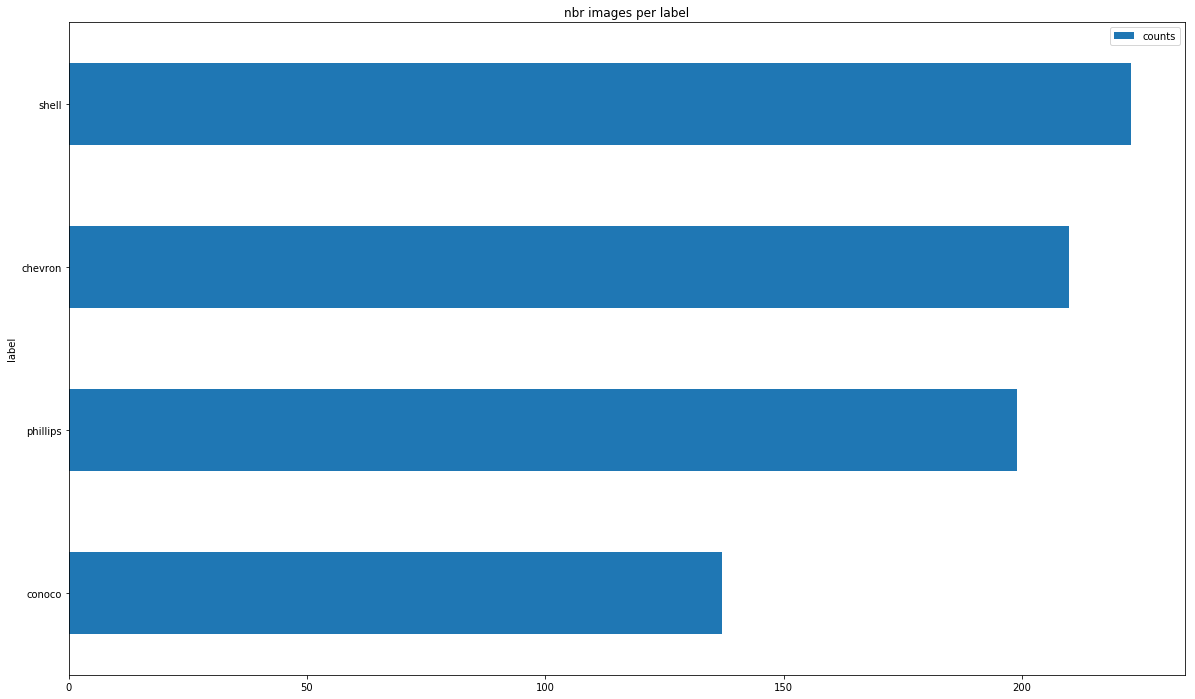

In [150]:
category_group = train[['fname', 'label']].groupby(['label']).count()
category_group.columns = ['counts']
print(f'The number of images per label ranges from {category_group.counts.min()} to {category_group.counts.max()}')
plot = category_group.sort_values(ascending=True, by='counts').plot(kind='barh', title='nbr images per label', figsize=(20,12))
plt.show()

We look at the smallest and largest dimensions, and check that all photos have 3 channels.



The smallest resolution is 
fname       chevron_213.jpg
label               chevron
xres                    150
yres                    150
channels                  3
xyres                 22500
Name: 563, dtype: object

The largest resolution is 
fname       chevron_96.jpg
label              chevron
xres                  5416
yres                  3504
channels                 3
xyres             18977664
Name: 89, dtype: object

The distribution of channels is given by:


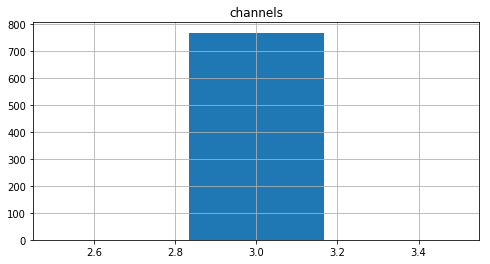

In [151]:
print(f'The smallest resolution is \n{train.iloc[train.xyres.idxmin()]}\n')
print(f'The largest resolution is \n{train.iloc[train.xyres.idxmax()]}\n')

print('The distribution of channels is given by:')

train.hist(column='channels', bins=3, figsize=(8,4))
plt.show()

Let's now visualize the distribution of their dimensions:

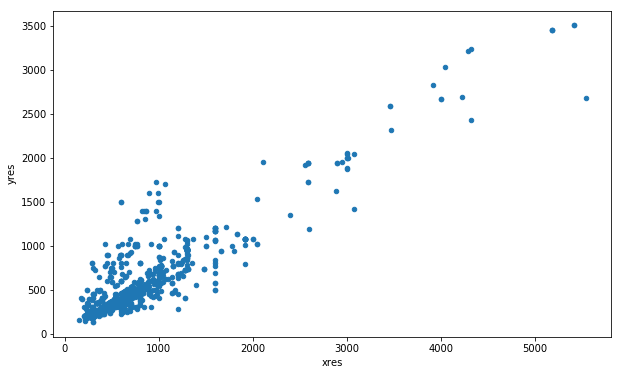

In [152]:
train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.show()

#train['nframes'] = train['fname'].apply(lambda fname : wave.open(os.path.join(dir_data, 'curated', fname)).getnframes())
#test['nframes'] = test['fname'].apply(lambda fname : wave.open(os.path.join(dir_data, 'test', fname)).getnframes())

We see that the scales are not the same and that most photos have a larger x-resolution. We will remove some outliers to avoid huge resolutions. Let's put the threshold at x-res < 2200.

In [153]:
nbr_im_large_xres = train[train.xres > 2200].shape[0]
total_im = train.shape[0]
train = train.query('xres < 2200')

print(f'There are {nbr_im_large_xres} images (out of {total_im}) with x-resolution larger than 2200. We remove them and we are left with {train.shape[0]} images.')

There are 39 images (out of 769) with x-resolution larger than 2200. We remove them and we are left with 730 images.


Here is the new distribution of dimensions.

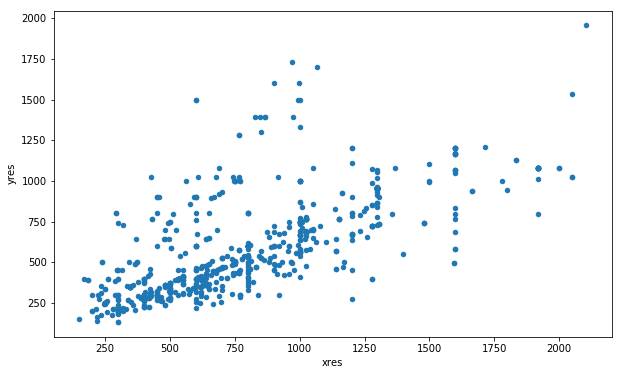

In [154]:
train.plot.scatter('xres', 'yres', figsize=(10,6))
plt.show()

Finally we now save this cleaned dataframe.

In [0]:
train.to_csv(os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'train.csv'), index=False)

# Construct The Model

First (Re)Load some Packages

In [175]:
import numpy as np
np.random.seed(1989)

import os, shutil, cv2
import pandas as pd

from albumentations import (Compose, HorizontalFlip, CLAHE, HueSaturationValue, RandomCrop,
    RandomBrightness, RandomContrast, RandomGamma, ToFloat, ShiftScaleRotate)


from sklearn.model_selection import StratifiedKFold
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, Input, MaxPool1D, concatenate) # for the 1D conv models
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, Activation, concatenate) # for the 2D models with MFCC
from keras.utils import Sequence, to_categorical
from keras import backend as K

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

Using TensorFlow backend.


If you skipped the visualization section, download the dataframe and load it here.

In [0]:
download = drive.CreateFile({'id': '1ffAPRILKnRgHgmVQ_fcVtYlsMk8-sPsT'})
download.GetContentFile('/content/train.csv')
train = pd.read_csv('/content/train.csv')


Set up some paths, some dictionnaries and set the filename as index for the training dataframe.

In [233]:
dir_data = '/content/data'

labels = train['label'].unique()
labels_to_idx = {label: i for i, label in enumerate(labels)}
print(labels_to_idx)

n_classes = len(labels)

min_height = train['yres'].min()
min_width = train['xres'].min()

train.set_index('fname', inplace=True, drop=True)
#test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: labels_to_idx[x])

train.head()

{'shell': 0, 'chevron': 1, 'phillips': 2, 'conoco': 3}


,label,xres,yres,channels,xyres,label_idx
fname,,,,,,
shell_44.png,shell,810,456,3,369360,0
chevron_22.jpg,chevron,700,525,3,367500,1
phillips_316.jpg,phillips,224,300,3,67200,2
chevron_91.jpg,chevron,1050,706,3,741300,1
chevron_248.jpg,chevron,400,300,3,120000,1


The Configuration class : In particular contains the default settings.

In [0]:
class Config(object):
	def __init__(self, model_name = 'dummy', n_classes=n_classes, image_size=(64,64,3), n_folds=1, learning_rate=0.0001, max_epochs=10):

		self.n_classes = n_classes
		self.image_size = image_size
		self.n_folds = n_folds
		self.learning_rate = learning_rate
		self.max_epochs = max_epochs
		self.model_name = model_name

The Datagenerator class : Inherits from Keras.utils.Sequence to efficiently feed the data.

I think that the normalization is done batch by batch, which is not good, as it's done the same way on the test set. 

In [0]:
class DataGenerator(Sequence): # Inherits from Keras.utils.Sequence for multiprocessing

    def __init__(self, config, dir_data, list_IDs, labels=None,
					batch_size=16, shuffle=False, augmentation = None, preprocessing_fn=None):
    
        self.config = config
        self.dir_data = dir_data
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.preprocessing_fn = preprocessing_fn
        self.shuffle = shuffle ## DOES IT WORK TO HAVE TRUE ?
        self.on_epoch_end()

    # returns the number of batches in the Sequence (usually per 1 epoch)
    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    # returns a complete batch at the place index
    def __getitem__(self,index):
        indexes_temp = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes_temp]
        return self.__data_generation(list_IDs_temp)

    # called at the end of an epoch: reloads IDs
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            #print('Got to the end of an epoch. Shuffling the dataset')
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.config.image_size)) 
        
        for i,ID in enumerate(list_IDs_temp):
            file_path = os.path.join(self.dir_data, ID)
            
            # read the image
            img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR) # NEED TO REVERT COLORS ?
            
            # other preprocesses (not augmenting though)
            if self.preprocessing_fn:
                img = self.preprocessing_fn(img) 
            
            # augment and save in the big array X
            if self.augmentation:
                img = self.augmentation(image=img)["image"]
            
            # if it wasn't cropped or resized yet, we resize it so that it has the std size
            if img.shape != self.config.image_size:
                print(img.shape)
                print(self.config.image_size)
                print('NEED TO RESIZE IMAGE --> Fix it by random cropping or something else')
                img = cv2.resize(img,(self.config.image_size[0],self.config.image_size[1]))
            
            X[i,] = img
            ### ADD HERE IMG VISUALIZATION or save in folder
        
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

Here is the dummy model with just a fully connected layer. Name = dummy

In [0]:
def get_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

And the larger 2D conv model. Name = conv

In [0]:
def get_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=config.image_size)
    x = Convolution2D(256, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

# Run The Model!

Set-up the Paths for the data

In [0]:
dir_log = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'logs')
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)

dir_pred = os.path.join(os.path.normpath(dir_data + os.sep + os.pardir), 'pred')
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)

dir_train = os.path.join(dir_data)
#dir_test = os.path.join(dir_data, 'test')

Creating the config and other necessary global objects that don't need to be reset after each k-fold.

In [259]:
config = Config(n_folds=5, model_name = 'conv', image_size=(min_height, min_width,3), learning_rate=0.001, max_epochs=5)

skf = StratifiedKFold(n_splits=config.n_folds)

augmentation_train = Compose([ 
    RandomCrop(min_height,min_width),
    #HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    #HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])

'''
augmentation_test = Compose([
    RandomCrop(64,64),
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])
'''


'\naugmentation_test = Compose([\n    RandomCrop(64,64),\n    # CLAHE(p=1.0, clip_limit=2.0),\n    ToFloat(max_value=255)\n])\n'

Run the Loop

In [261]:
if os.path.isdir(dir_log):
        shutil.rmtree(dir_log)
if os.path.isdir(dir_pred):
    shutil.rmtree(dir_pred)
os.mkdir(dir_pred)

for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    K.clear_session()
    
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    
    callbacks_list= []
    
    # the checkpoint is causing issues with colab and breaks in the middle of training. A workaround is the restore_best_weights from EarlyStopping
    #checkpoint = ModelCheckpoint(os.path.join(dir_log,'best_%d.h5'%i), monitor='val_loss', verbose=1, save_best_only=True)
    #callbacks_list.append(checkpoint)  
    
    early = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    callbacks_list.append(early)
    
    tb = TensorBoard(log_dir= os.path.join(dir_log, 'fold_%d'%i), write_graph=True)
    callbacks_list.append(tb)
    
    print("#"*50)
    print(f'\nFold {i}')
    
    if config.model_name == 'conv':
        model = get_conv_model(config)
    else:
        model = get_dummy_model(config)
    
    train_generator = DataGenerator(config, dir_data=dir_train, list_IDs=train_set.index, labels=train_set.label_idx, shuffle=True, augmentation = augmentation_train)
    val_generator = DataGenerator(config, dir_data=dir_train, list_IDs=val_set.index, labels=val_set.label_idx, shuffle=True, augmentation = augmentation_train)

    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator, epochs=config.max_epochs, use_multiprocessing=True, max_queue_size=20)
    
    print('Saving the weights.')
    model.save(os.path.join(dir_log,'best_%d.h5'%i))
    
    # training done, now load best model (at what epoch it was best) and predict
    model.load_weights(os.path.join(dir_log,'best_%d.h5'%i))
    
    # save train prediction for error analysis
    train_generator = DataGenerator(config, dir_data=dir_train, list_IDs=train_set.index, labels=train_set.label_idx, augmentation = augmentation_train, batch_size=16) 
    
    print('Doing now predictions on the training set from the saved model.')
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    print('Predictions done. Saving the results.')
    np.save(os.path.join(dir_pred, 'train_pred_%d.npy'%i), predictions)
    
    '''
    # save test prediction
    test_generator = DataGenerator(config, dir_test, test.index, labels=None,
					batch_size=64)
    
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, max_queue_size=20, verbose=1)
    np.save(os.path.join(dir_pred, 'test_pred_%d.npy'%i), predictions)
    pred_test_shape = predictions.shape

    # Make a submission file
    top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(os.path.join(dir_pred, 'predictions_%d.csv'%i))
    '''

##################################################

Fold 0
Epoch 1/5
31/31 [==============================] - 12s 373ms/step - loss: 1.5585 - acc: 0.3072 - val_loss: 3.4558 - val_acc: 0.3429
Epoch 1/5
Epoch 2/5
31/31 [==============================] - 9s 306ms/step - loss: 1.3672 - acc: 0.3773 - val_loss: 1.6880 - val_acc: 0.3265
Epoch 3/5
31/31 [==============================] - 10s 311ms/step - loss: 1.3232 - acc: 0.3738 - val_loss: 1.6312 - val_acc: 0.4041
Epoch 4/5
31/31 [==============================] - 10s 322ms/step - loss: 1.3126 - acc: 0.4446 - val_loss: 1.8521 - val_acc: 0.4000
Epoch 5/5
31/31 [==============================] - 10s 314ms/step - loss: 1.3158 - acc: 0.3919 - val_loss: 1.4238 - val_acc: 0.4367


KeyboardInterrupt: ignored

Ensemble the Predictions

In [0]:
pred_list = []

for i in range(config.n_folds):
    pred_list.append(np.load(os.path.join(dir_pred, 'test_pred_%d.npy'%i)))
    
prediction = np.ones_like(pred_list[0])

# Taking a geometric mean of the probabilities
for pred in pred_list:
    prediction = prediction*pred
prediction_gm = prediction**(1./len(pred_list))

# Make a submission file
top_3 = np.array(labels)[np.argsort(-prediction_gm, axis=1)[:, :3]]

predicted_labels = [' '.join(list(x)) for x in top_3]

submission = pd.read_csv(os.path.join(dir_data, 'sample_submission.csv'))

submission['label'] = predicted_labels
submission[['fname', 'label']].to_csv(os.path.join(dir_data, 'submission.csv'), index=False)

We now save the logs, pr

In [0]:
from datetime import datetime
datetime_now = str(datetime.now()).replace('-','').replace(':','').replace(' ','')
datetime_now = datetime_now[:datetime_now.find('.')]
datetime_now = datetime_now[4:8] + '_' + datetime_now[-6:-2]

# save the logs
zipname = datetime_now + '_log.zip'
!zip -r /content/"$zipname" /content/logs
files.download(os.path.join(dir_data, zipname))

# save the preds
zipname = datetime_now + '_pred.zip'
!zip -r /content/"$zipname" /content/pred
files.download(os.path.join(dir_data, zipname))

# save the submission
zipname = datetime_now + '_submission.zip'
!zip -r /content/"$zipname" /content/submission.csv
files.download(os.path.join(dir_data, zipname))